In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import statsmodels.api as sm
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from helpers import *

mypal = make_aesthetic(with_gridlines=False)

# Read in data

In [3]:
data_pts = []

df = pd.read_csv('../data/raw/qualtrics_annotation2.csv')
df = df.iloc[2:]
print(df.columns)

for idx, row in df.iterrows():
    uid = row['ResponseId']
    duration = float(row['Duration (in seconds)'])/60
    age = row['age']
    gender = row['gender']
    ideo = row['ideo']
    educ = row['educ']
    commit = row['commitment check']

    for i in range(1,31):
        for condition in ['rational', 'emotional']:
            data_pt = {
                'uid': uid,
                'condition': condition,
                'loop_merge_idx': i,
                'unique_case_condition': f'{i}_{condition}',
                'unique_case': f'{i}',
                'duration': duration,
                'age': age,
                'gender': gender, 
                'ideo': ideo,
                'educ': educ,
                'commit': commit, 
                'choice': row[f'{i}_{condition}_lm']
            }
            data_pts.append(data_pt)


def clean_choice(x):
    if "Field/3" in x:
        return "rational"
    elif "Field/4" in x:
        return "emotional"
    else:
        raise ValueError

choice_map = {"${lm://Field/3}", "rational", "${lm://Field/4}", "emotional"}
df = pd.DataFrame(data_pts)
df = df.dropna()
df['clean_choice'] = df['choice'].apply(clean_choice)

df['correct'] = df['condition']==df['clean_choice']
df['clean_condition'] = df['condition'].apply(lambda x: x.title())

# assertions 
assert df['uid'].nunique()==20, "not 20 ppl"
assert df['condition'].nunique()==2, "not 2 conditions"
assert len(df)==200, "not 200 data pts"

df.to_csv('../data/processed/clean_annotation_data.csv', index=False)



Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'prolific_id',
       'commitment check', '1_rational_lm', '2_rational_lm', '3_rational_lm',
       '4_rational_lm', '5_rational_lm', '6_rational_lm', '7_rational_lm',
       '8_rational_lm', '9_rational_lm', '10_rational_lm', '11_rational_lm',
       '12_rational_lm', '13_rational_lm', '14_rational_lm', '15_rational_lm',
       '16_rational_lm', '17_rational_lm', '18_rational_lm', '19_rational_lm',
       '20_rational_lm', '21_rational_lm', '22_rational_lm', '23_rational_lm',
       '24_rational_lm', '25_rational_lm', '26_rational_lm', '27_rational_lm',
       '28_rational_lm', '29_rational_lm', '30_rational_lm', '1_emotional_lm',
       '2_emotional_lm', '3_emotional

# Analysis

In [4]:

from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import binom_test

def print_ci(x):
    n = len(x)
    count = x.sum()
    lower, upper = proportion_confint(count=count, nobs=n, alpha=0.05)
    p = binom_test(count, n, 0.5)
    print(f"{count/n:.2f}, (95\% CI = [{lower:.2f}, {upper:.2f}])")
    print("Binomial p", p)



# Accuracy CIs

print("overall")
print_ci(df['correct'])

for condition in ['rational', 'emotional']:
    print(condition)
    print_ci(df[df['condition']==condition]['correct'])

rational_acc = df[df['condition']=='rational']['correct'].mean()
emotional_correct = df[df['condition']=='emotional']['correct'].sum()
emotional_n = len(df[df['condition']=='emotional'])
print("Does emotional condition have stat sig diff accuracy?")
print(binom_test(emotional_correct, emotional_n, rational_acc))
duration = pretty_print_desc_stats(df['duration'])
print("Duration in minutes", duration)


overall
0.89, (95\% CI = [0.84, 0.93])
Binomial p 1.2434522550868792e-30
rational
0.93, (95\% CI = [0.88, 0.98])
Binomial p 6.8377855268965755e-22
emotional
0.83, (95\% CI = [0.76, 0.91])
Binomial p 9.176485495714726e-11
Does emotional condition have stat sig diff accuracy?
0.0031935520622378673
Duration in minutes $M = 8.06, Mdn = 7.10, SD = 3.54$


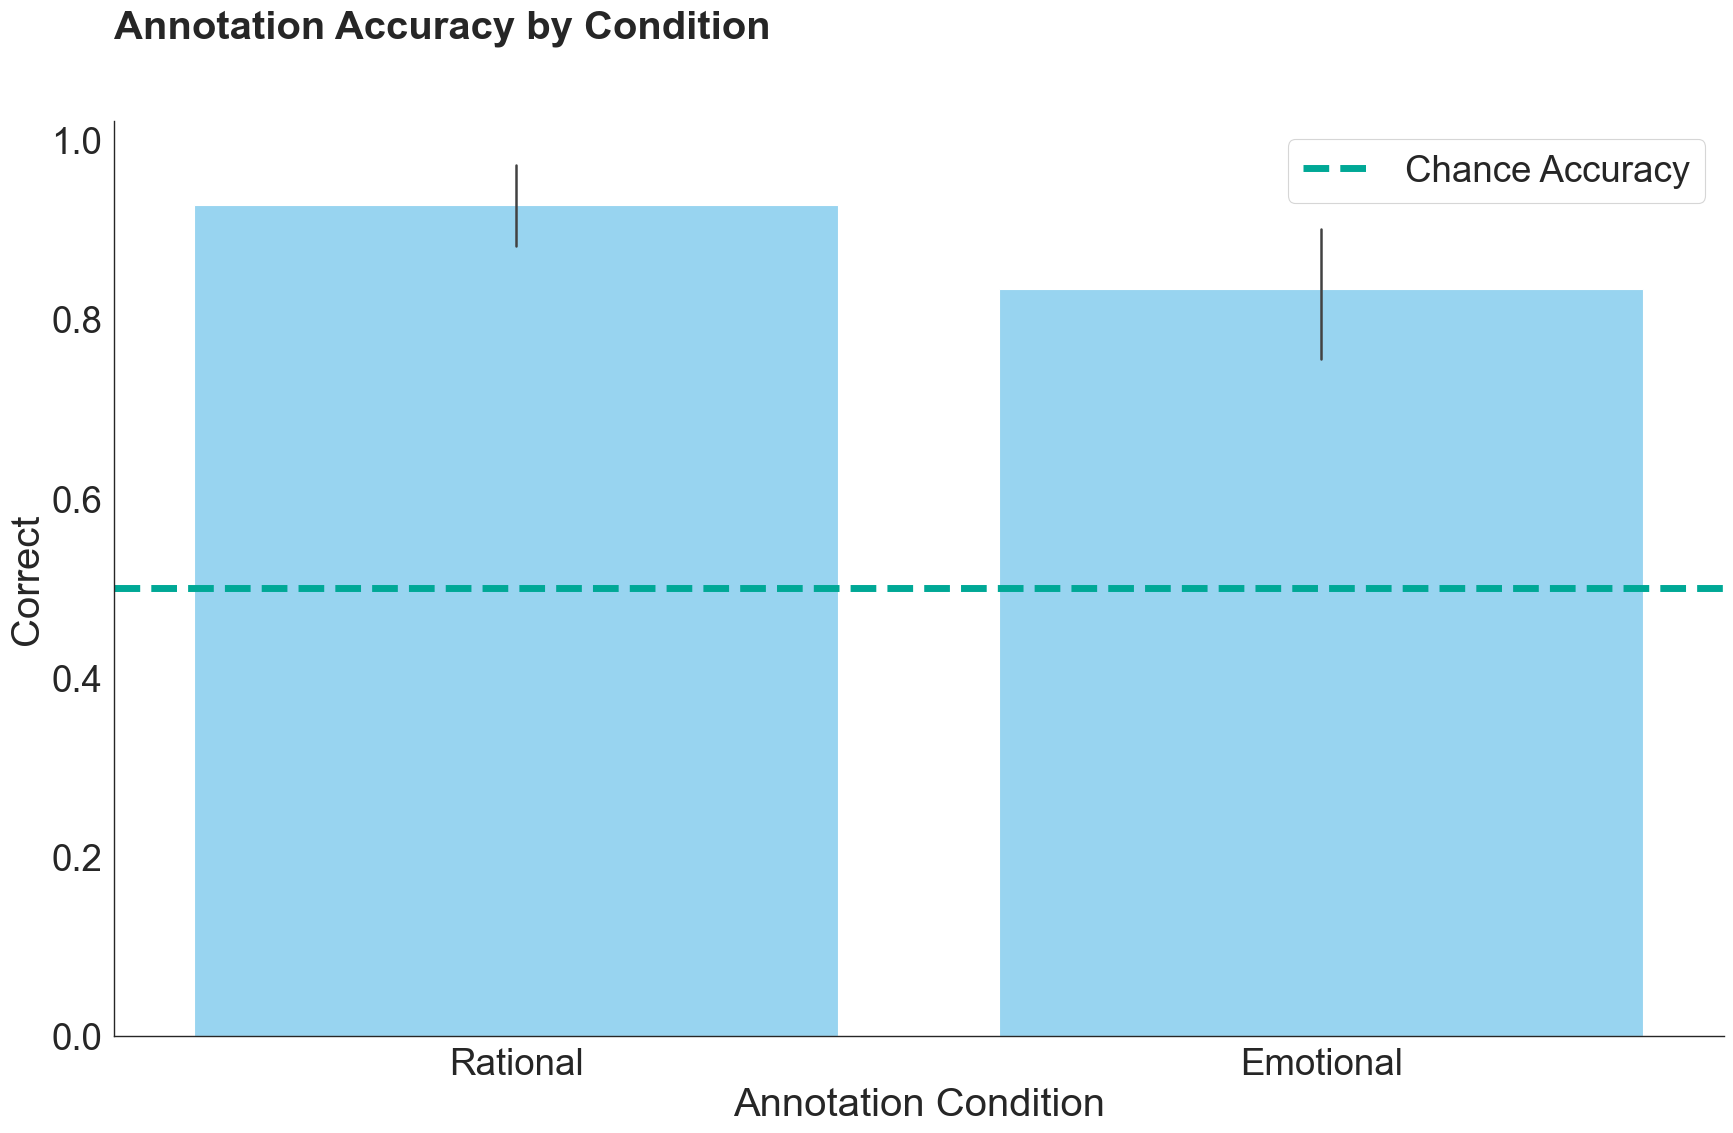

In [25]:
plt.figure(figsize=(18,12))
pal = make_aesthetic(font_scale=3)
sns.barplot(data=df, x='clean_condition', y='correct')
plt.xlabel('Annotation Condition')
plt.ylabel("Correct")
plt.axhline(y=0.5, color=pal[2], linestyle='--', label='Chance Accuracy', linewidth=5)

# add legend for random chance
plt.legend()
plt.title("Annotation Accuracy by Condition", fontweight='bold')
plt.savefig('../plots/annotation_accuracy.pdf')